### MonthlySVD
This code shows as simple way to:
- Read in a .nc file using xarray
- Generate montly anomalies from climatology of monthly means
- detrend data by grid cell
- calculate singular value decomposition by grid cell, dim = month * year


In [1]:
import xarray as xr
import cf_units as cf
import numpy as np
import pandas as pd
import esmlab
from ctsm_py import utils
import segment as sg
import scipy                    # Try scipy to detrend
from scipy import signal

# some resources for plotting
import matplotlib.pyplot as plt
#import cartopy
#import cartopy.crs as ccrs
%matplotlib inline

#### Read in data

In [2]:
## User defined options
model = 'CLM5_GSWP3'
variables = ['GPP','TBOT','SOILWATER_10CM']
pattern = '/glade/p/cgd/tss/people/oleson/CLM_LAND_ONLY_RELEASE/CLM5/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist/'\
    'lnd/proc/tseries/month_1/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist.clm2.h0.{var}.185001-201412.nc'
files = [pattern.format(var=var) for var in variables]

# utils.time_set_mid corrects dates, to get Jan of first year
ds = utils.time_set_mid(xr.open_mfdataset(files, combine='by_coords', decode_times=True), 'time') # combine needed for newer xarray versions

In [3]:
var = variables   #redundant, but we'll keep using this for now because 'var' is used more later on...
area = ds.area
landfrac = ds.landfrac

## --- This is example code to make sure things are working ---
###          Quick look at annual cycle for a grid cell

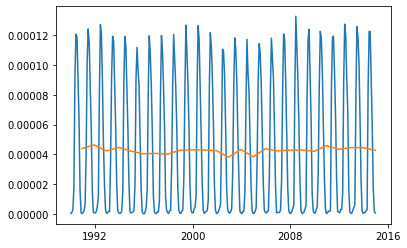

In [4]:
years = 25
months = years * 12
tlat =  60  #-3
tlon =  240 #280
ds_test = ds.sel(lat=tlat, lon=tlon, method='nearest') #select a single grid point to work with first
ds_last = ds_test.isel(time=slice(-months,None))
dataset = ds_last.get(var)
ds_ann  = dataset.apply(utils.weighted_annual_mean)
plt.plot(ds_last.time['time'], ds_last.get(var[0]), '-' );
plt.plot(ds_ann.time['time'], ds_ann.get(var[0]), '-' );

### Calculate climatology and anomalies

/glade/u/home/wwieder/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/xarray/core/indexing.py:1302: PerformanceWarning: Slicing with an out-of-order index is generating 25 times more chunks
  return self.array[key]


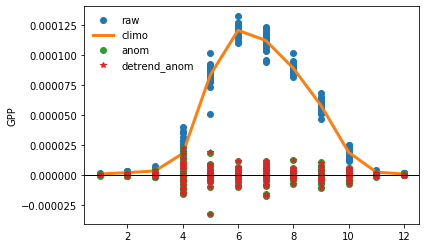

In [5]:
# esmlab anomaly function needs time_bounds in the dataset!
# test to see of climatology and anomaly functions see to work appropriately?
ds_climo = esmlab.core.climatology(ds_last,freq='mon')
ds_anom = esmlab.core.anomaly(ds_last, clim_freq='mon', time_coord_name='time')
ds_detrend = ds_anom.get(var).map(signal.detrend)   # still need to use get so detrend works

# JH doesn't like using generic variables here, but 
# I'm going leave this for now, because the analysis may not always focus on GPP.
plt.plot(ds_last.time['time.month'], ds_last.get(var[0]), 'o' );
plt.plot(ds_climo.time['time.month'], ds_climo.get(var[0]), '-', lw=3 );
plt.plot(ds_anom.time['time.month'], ds_anom.get(var[0]), 'o' );
plt.plot(ds_anom.time['time.month'], ds_detrend.get(var[0]), '*' );
plt.legend(labels=('raw','climo','anom','detrend_anom'),frameon = False)
plt.axhline(0, color='black', lw=1);
plt.ylabel(var[0]);

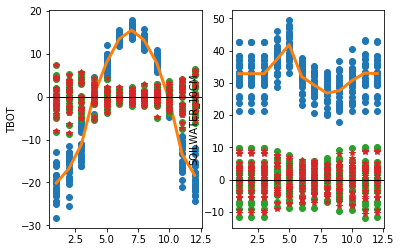

In [6]:
# now look at temp and soil moisture anomalies
plt.subplot(1, 2, 1)
plt.plot(ds_last.time['time.month'], ds_last.get(var[1])-273.15, 'o' );
plt.plot(ds_climo.time['time.month'], ds_climo.get(var[1])-273.15, '-', lw=3 );
plt.plot(ds_anom.time['time.month'], ds_anom.get(var[1]), 'o' );
plt.plot(ds_anom.time['time.month'], ds_detrend.get(var[1]), '*' );
plt.axhline(0, color='black', lw=1);
plt.ylabel(var[1])

plt.subplot(1, 2, 2)
plt.plot(ds_last.time['time.month'], ds_last.get(var[2]), 'o' );
plt.plot(ds_climo.time['time.month'], ds_climo.get(var[2]), '-', lw=3 );
plt.plot(ds_anom.time['time.month'], ds_anom.get(var[2]), 'o' );
plt.plot(ds_anom.time['time.month'], ds_detrend.get(var[2]), '*' );
plt.axhline(0., color='black', lw=1);
plt.ylabel(var[2]);

 ### Do we need to detrend data?

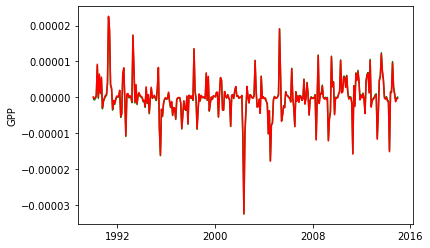

In [7]:
plt.plot(ds_anom.time['time'], ds_anom.get(var[0]), '-',c='green' )
plt.plot(ds_anom.time['time'], ds_detrend.get(var[0]), '-' ,c='red')
plt.ylabel(var[0]);

### Start singular vector decomposition
#### This is from Gretchen's CLM_SVD code 

(12, 25)


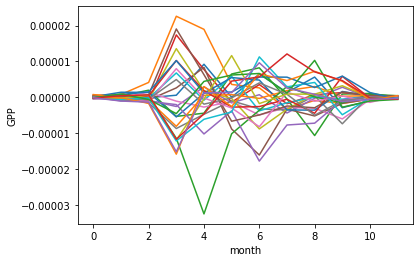

In [8]:
# orig. mon x year
iavmatrix_0 =np.zeros([12, years])
iavmatrix_1 =np.zeros([12, years])
iavmatrix_2 =np.zeros([12, years])
for iyr in range(years):
    iavmatrix_0[0:12, iyr]=ds_detrend.get(var[0])[iyr*12:(iyr+1)*12] #reshape timeseries vector into a matrix (year x month) 
    iavmatrix_1[0:12, iyr]=ds_detrend.get(var[1])[iyr*12:(iyr+1)*12] #reshape timeseries vector into a matrix (year x month) 
    iavmatrix_2[0:12, iyr]=ds_detrend.get(var[2])[iyr*12:(iyr+1)*12] #reshape timeseries vector into a matrix (year x month) 

print(iavmatrix_0.shape)

plt.figure();
plt.plot(iavmatrix_0) #this plots months on x-axis, 1 line/year
plt.ylabel(var[0])
plt.xlabel('month');

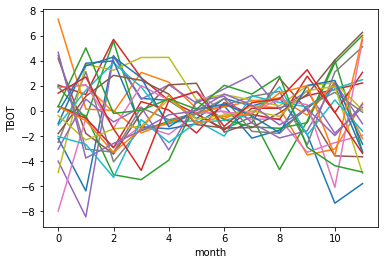

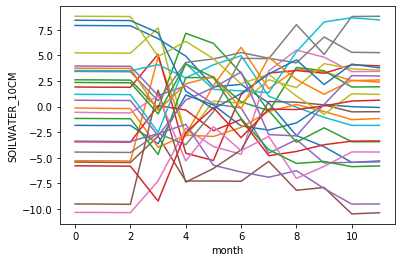

In [9]:
plt.figure();
plt.plot(iavmatrix_1) #this plots months on x-axis, 1 line/year
plt.ylabel(var[1])
plt.xlabel('month');

plt.figure();
plt.plot(iavmatrix_2) #this plots months on x-axis, 1 line/year
plt.ylabel(var[2])
plt.xlabel('month');

### Now try using SVD_tools.py
This code was provided by Gretchen Keppel-Aleks & initially developed by Zach Butterfield

Further modified by W. Wieder to accept matrix when years > 12 (nmonths)
- Decompose function accepts a month * year matrix and calculates vectors (dimensions = years,months) and weights (years,years)  
- Redistribution function takes vectors, weights, and matrix to calculate theta (years), & varfrac (years)

In [10]:
import SVD_tools as svd
#assign the 2-D matrix (month x year) to decompose
vectors, weights=svd.decompose(iavmatrix_0) #Call the function to calculate the singular vectors and their annual weights
vectors1, weights1=svd.decompose(iavmatrix_1) 
vectors2, weights2=svd.decompose(iavmatrix_2) 

theta ,varfrac =svd.calc_redistribution(vectors , weights , iavmatrix_0)
theta1,varfrac1=svd.calc_redistribution(vectors1, weights1, iavmatrix_1)
theta2,varfrac2=svd.calc_redistribution(vectors2, weights2, iavmatrix_2)

/glade/u/home/wwieder/python/ctsm_py/notebooks/SVD_tools.py:60: RuntimeWarning: invalid value encountered in double_scalars
  sv_theta[i] = np.abs(np.nansum(sv_vectors[i,:]))/np.nansum(np.abs(sv_vectors[i,:]))


In [11]:
# also try spearman's rank correlation
from scipy.stats import spearmanr
mm2plot=ds_climo.get(var[0])
corr0, _ = spearmanr(mm2plot,vectors[0,:])
corr1, _ = spearmanr(mm2plot,vectors[1,:])
print('Spearmans correlation SV1-Climo: %.3f' % corr0)
print('Spearmans correlation SV2-Climo: %.3f' % corr1)

# also try weighting correlation based on monthly contribution to annual flux
wgt = mm2plot/mm2plot.sum()

# code bit below is identical to np.average
#def m(x, w):
#    """Weighted Mean"""
#    return np.sum(x * w) / np.sum(w)

def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - np.average(x, weights=w)) * (y - np.average(y, weights=w))) / np.sum(w)

def corr(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))
r1 = corr(mm2plot.values,vectors[0,:], wgt.values)
r2 = corr(mm2plot.values,vectors[1,:], wgt.values)


#temp = m(mm2plot.values, wgt.values)
#print(m)
print('weighted correlation SV1-Climo: %.3f' % r1)
print('weighted correlation SV2-Climo: %.3f' % r2)

Spearmans correlation SV1-Climo: 0.399
Spearmans correlation SV2-Climo: -0.804
weighted correlation SV1-Climo: 0.401
weighted correlation SV2-Climo: -0.571


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


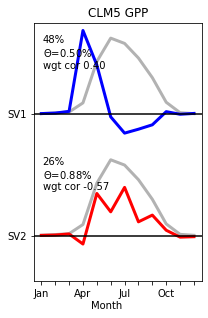

In [12]:
# Plot First and Second Singular Vectors
# TODO This is a pretty complicated plotting method that could likely be improved & made into a function
# That said, the it makes nice, clear plots... we'll keep it for now

fig = plt.figure(4,figsize=(3,4.5))
ax1 = fig.add_subplot(111)
month = np.arange(12)
barwidth = 0.2
ymax=np.max(vectors)
vectors2plot=vectors*7000  #This is a totally arbitrary scale factor, decided by me, to make figures look good!
ax1.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))-0.05,'k-',alpha=0.3,linewidth=3)
ax1.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))+0.35,'k-',alpha=0.3,linewidth=3)
ax1.plot(np.array(month)+2*barwidth,-vectors2plot[0,:]*0.75+0.35,'b-',linewidth=3)
ax1.plot(np.array(month)+2*barwidth,-vectors2plot[1,:]*0.75-0.05,'r-',linewidth=3)
ax1.axhline(-0.05,color='black')
ax1.axhline(0.35,color='black')
ax1.set_xticks(np.array(month)+2*barwidth)
ax1.set_xticklabels(['Jan','','','Apr','','','Jul','','','Oct','',''])
ax1.set_yticks([-0.05,0.35])
ax1.set_yticklabels(['SV2','SV1'])
ax1.set_ylim([-0.2,0.65])
ax1.text(0.5,.50,str(int(varfrac[0]*100))+"%\n$\Theta$="+str('%.2f'%theta[0])+
        "%\n"+str('wgt cor %.2f' % r1))
ax1.text(0.5,.10,str(int(varfrac[1]*100))+"%\n$\Theta$="+str('%.2f'%theta[1])+
        "%\n"+str('wgt cor %.2f' % r2))

#ax1.text(0.5,.55,str('rank cor %.2f' % corr0))
#ax1.text(0.5,.15,str('rank cor %.2f' % corr1))

ax1.title.set_text('CLM5 '+var[0])
ax1.text(4,-0.29,'Month')
plt.tight_layout()
plt.savefig('SVD_CLM5_ex_GPP.eps') ;


<xarray.Dataset>
Dimensions:  ()
Coordinates:
    lat      float32 59.842934
    lon      float32 240.0
Data variables:
    r        float64 -5.836e-18
    p        float64 1.0
[[1.         0.17786995]
 [0.17786995 1.        ]]
[[ 1.         -0.84945569]
 [-0.84945569  1.        ]]


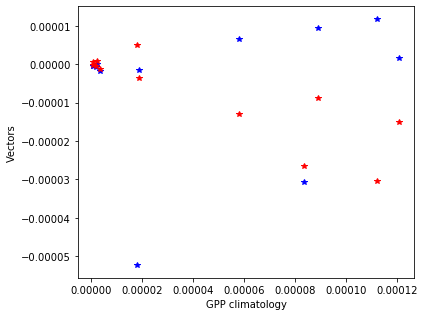

In [13]:
# Can correlations between climatology and Vectors tell us someting about the nature of relationships?
# In this example SV2 shows higher correlation with climatology of GPP
fig = plt.figure(4,figsize=(6,4.5))
ax1 = fig.add_subplot(111)
month = np.arange(12)
barwidth = 0.2
ymax=np.max(vectors)
mm2plot=ds_climo.get(var[0])
ax1.plot(mm2plot, vectors[0,:], '*',c='b')
ax1.plot(mm2plot, vectors[1,:], '*',c='r')
plt.xlabel('GPP climatology')
plt.ylabel('Vectors')
plt.tight_layout();

x  = xr.DataArray(data=mm2plot)
y0 = xr.DataArray(data=vectors[0,:])
y1 = xr.DataArray(data=vectors[1,:])
temp = esmlab.statistics.weighted_corr(x,y1  )
print(temp)
cor1 = np.corrcoef(mm2plot,vectors[0,:])
cor2 = np.corrcoef(mm2plot,vectors[1,:])
print(cor1 )
print(cor2 )

Spearmans correlation GPP1, TBOT1: -0.350 weighted : -0.601
Spearmans correlation GPP1, TBOT2: -0.503 weighted : -0.435
Spearmans correlation GPP2, TBOT1: -0.329 weighted : -0.127
Spearmans correlation GPP2, TBOT2: 0.552 weighted : 0.418



/glade/u/home/wwieder/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Spearmans correlation GPP1, SoiMoi1: 0.049 weighted : -0.187
Spearmans correlation GPP1, SoiMoi2: 0.371 weighted : 0.608
Spearmans correlation GPP2, SoiMoi1: -0.294 weighted : 0.373
Spearmans correlation GPP2, SoiMoi2: 0.007 weighted : 0.320


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


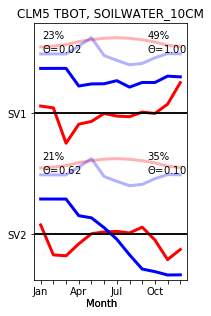

In [14]:
## Temperature, Plot First and Second Singular Vectors
fig = plt.figure(4,figsize=(3,4.5))
ax1 = fig.add_subplot(111)
barwidth = 0.2
ymax=np.max(vectors1)
#print(ymax)
r0 = corr(vectors1[0,:],vectors[0,:], wgt.values)
r1 = corr(vectors1[1,:],vectors[0,:], wgt.values)
r2 = corr(vectors1[0,:],vectors[1,:], wgt.values)
r3 = corr(vectors1[1,:],vectors[1,:], wgt.values)
#print(ymax)
corr0, _ = spearmanr(vectors1[0,:],vectors[0,:])
corr1, _ = spearmanr(vectors1[1,:],vectors[0,:])
corr2, _ = spearmanr(vectors1[0,:],vectors[1,:])
corr3, _ = spearmanr(vectors1[1,:],vectors[1,:])
print('Spearmans correlation GPP1, TBOT1: %.3f' % corr0, 'weighted : %.3f' % r0)
print('Spearmans correlation GPP1, TBOT2: %.3f' % corr1, 'weighted : %.3f' % r1)
print('Spearmans correlation GPP2, TBOT1: %.3f' % corr2, 'weighted : %.3f' % r2)
print('Spearmans correlation GPP2, TBOT2: %.3f' % corr3, 'weighted : %.3f' % r3)
print()

vectors2plot=vectors1 *0.01 #This is a totally arbitrary scale factor, decided by me, to make figures look good!
#mm2plot=mm
mm2plot=ds_climo.get(var[1])
ax1.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))-0.05,'r-',alpha=0.3,linewidth=3)
ax1.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))+0.35,'r-',alpha=0.3,linewidth=3)
ax1.plot(np.array(month)+2*barwidth,-vectors2plot[0,:]*0.75+0.35,'r-',linewidth=3)
ax1.plot(np.array(month)+2*barwidth,-vectors2plot[1,:]*0.75-0.05,'r-',linewidth=3)
ax1.axhline(-0.05,color='black')
ax1.axhline(0.35,color='black')
ax1.set_xticks(np.array(month)+2*barwidth)
ax1.set_xticklabels(['Jan','','','Apr','','','Jul','','','Oct','',''])
ax1.set_yticks([-0.05,0.35])
ax1.set_yticklabels(['SV2','SV1'])
ax1.set_ylim([-0.2,0.65])
ax1.text(0.5,.55,str(int(varfrac1[0]*100))+"%\n$\Theta$="+str('%.2f'%theta1[0]))
ax1.text(0.5,.15,str(int(varfrac1[1]*100))+"%\n$\Theta$="+str('%.2f'%theta1[1]))
ax1.title.set_text('CLM5 '+var[1]+", "+var[2])
ax1.text(4,-0.29,'Month')
plt.tight_layout();

ax2 = fig.add_subplot(111)
month = np.arange(12)
barwidth = 0.2
ymax=np.max(vectors2)

r0 = corr(vectors2[0,:],vectors[0,:], wgt.values)
r1 = corr(vectors2[1,:],vectors[0,:], wgt.values)
r2 = corr(vectors2[0,:],vectors[1,:], wgt.values)
r3 = corr(vectors2[1,:],vectors[1,:], wgt.values)

#print(ymax)
corr0, _ = spearmanr(vectors2[0,:],vectors[0,:])
corr1, _ = spearmanr(vectors2[1,:],vectors[0,:])
corr2, _ = spearmanr(vectors2[0,:],vectors[1,:])
corr3, _ = spearmanr(vectors2[1,:],vectors[1,:])
print('Spearmans correlation GPP1, SoiMoi1: %.3f' % corr0, 'weighted : %.3f' % r0)
print('Spearmans correlation GPP1, SoiMoi2: %.3f' % corr1, 'weighted : %.3f' % r1)
print('Spearmans correlation GPP2, SoiMoi1: %.3f' % corr2, 'weighted : %.3f' % r2)
print('Spearmans correlation GPP2, SoiMoi2: %.3f' % corr3, 'weighted : %.3f' % r3)

vectors2plot=vectors2 *0.01 #This is a totally arbitrary scale factor, decided by me, to make figures look good!
#mm2plot=mm
mm2plot=ds_climo.get(var[2])
ax2.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))-0.05,'b-',alpha=0.3,linewidth=3)
ax2.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))+0.35,'b-',alpha=0.3,linewidth=3)
ax2.plot(np.array(month)+2*barwidth,-vectors2plot[0,:]*0.75+0.35,'b-',linewidth=3)
ax2.plot(np.array(month)+2*barwidth,-vectors2plot[1,:]*0.75-0.05,'b-',linewidth=3)
ax2.axhline(-0.05,color='black')
ax2.axhline(0.35,color='black')
ax2.set_xticks(np.array(month)+2*barwidth)
ax2.set_xticklabels(['Jan','','','Apr','','','Jul','','','Oct','',''])
ax2.set_yticks([-0.05,0.35])
ax2.set_yticklabels(['SV2','SV1'])
ax2.set_ylim([-0.2,0.65])
ax2.text(8.8,.55,str(int(varfrac2[0]*100))+"%\n$\Theta$="+str('%.2f'%theta2[0]))
ax2.text(8.8,.15,str(int(varfrac2[1]*100))+"%\n$\Theta$="+str('%.2f'%theta2[1]))
ax1.title.set_text('CLM5 '+var[1]+", "+var[2])
ax2.text(4,-0.29,'Month')

plt.tight_layout();
plt.savefig('SVD_CLM5_ex_climo.eps') ;


## --- End of example code  ---

## Calculate global anomalies

In [15]:
# Use esmlab to calculate climatology & anomalies

# TODO, refer to variables by name (e.g. anom_gpp) to improve readability
# Will leave this for now to have a more generalizable code

ds2 = ds.isel(time=slice(-months,None))             # Select last N years of data
ds_climo = esmlab.core.climatology(ds2,freq='mon')  # Calculate climatology
ds_anom  = esmlab.core.anomaly(ds2, clim_freq='mon', time_coord_name='time') #not sure how to use slice_mon_clim_time
anom_0   = ds_anom.get(var[0])                   # returns a xr.DataArray with dims (time,lat,lon)
anom_0   = anom_0.where(anom_0.max(dim='time') )
#anom_0   = anom_0.where(anom_0.notnull())
#anom_0  = anom_0.notnull()
#print(anom_0)

/glade/u/home/wwieder/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/xarray/core/indexing.py:1302: PerformanceWarning: Slicing with an out-of-order index is generating 25 times more chunks
  return self.array[key]


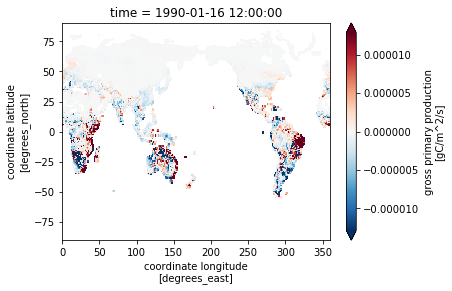

In [23]:
#plot look at anomalies at the first time slice

anom_0.isel(time=0).plot(robust=True);
#anom_0 = anom_0.values   # now get the np array

#### Define wrapper function that includes: 
- Detrending, reshaping, SVD & 
- Returns a np.array with vectors, weights, theta & varfrac

In [24]:
def svd_wrap(anom, years=years):
    theta = np.full(years, np.nan)
    varfrac = np.full(years, np.nan)
    if np.isnan(anom)[0] == False:
        #detrend results, if needed
        detrend = signal.detrend(anom)  
    
        #reshape timeseries vector into a matrix (year x month) 
        matrix=np.zeros([12, years])
        for iyr in range(years):
            matrix[0:12, iyr]=detrend[iyr*12:(iyr+1)*12] 
    
        #Call the function to calculate the singular vectors and their annual weights
        [vectors, weights]=svd.decompose(matrix) 
        [theta,varfrac]=svd.calc_redistribution(vectors, weights, matrix)

    return theta, varfrac, vectors, weights

In [25]:
## Select a single grid point to work with first
#ds_temp = ds_anom.sel(lat=tlat, lon=tlon, method='nearest') 
##print(ds_temp.get(var[0]))

## Make sure wrapper results are the same as above
#[theta_wrap, varfrac_wrap, vectors_wrap, weights_wrap] = svd_wrap(ds_temp.get(var[0]).values, years)
#plt.plot(theta_wrap - theta, '*') ;
#plt.plot(varfrac_wrap - varfrac, '*',c='r') ;
#print ('differences between results look prety small')

#### Make frunction to Loop through each grid cell & dataset to save output
- Would Dask make this faster?
- how do we also mask non-veg land cells?


In [26]:
# TODO, this is the time consuming bit of the code.
# JH recommends using map_blocks, once it's developed farther

def calc_svd(da, nyears=years):
    dims = dict(zip(da.dims, da.shape))
    yx_shape = (dims['lat'], dims['lon'])
    # setup output variables
    theta_shape = yx_shape + (nyears, )
    vector_shape = yx_shape + (nyears, 12)
    weights_shape = yx_shape + (nyears, nyears)
    
    out = xr.Dataset( coords={"lat": da.lat, "lon": da.lon } )

    varnames = ['theta', 'varfrac', 'vectors', 'weights']
    out['theta'] = xr.DataArray(np.zeros(theta_shape), dims=('lat', 'lon', 'thetadim'))
    out['varfrac'] = xr.DataArray(np.zeros(theta_shape), dims=('lat', 'lon', 'thetadim'))
    out['vectors'] = xr.DataArray(np.zeros(vector_shape), dims=('lat', 'lon', 'vectors_dim1', 'time'))
    out['weights'] = xr.DataArray(np.zeros(weights_shape), dims=('lat', 'lon', 'weights_dim1', 'weights_dim2'))

    for (i, j), mask in np.ndenumerate(da.isel(time=0).isnull()):
        if not mask:
            return_vals = svd_wrap(da.isel(lat=i, lon=j).data)

            for varname, vals in zip(varnames, return_vals):
                out[varname][i, j, ...] = vals

    return out

In [27]:
# Now try this on the full dataset
# generate data arrays from anomaly data to feed into function
# TODO, again more descriptive names will make the code easier to read, but for now keeping general 

ds_anom = ds_anom.where(ds_anom.get(var[0]).max(dim='time'))    #mask out regions with no GPP in all variables
da0 = ds_anom.get(var[0])  
da1 = ds_anom.get(var[1])  
da2 = ds_anom.get(var[2])  
print(da0)

<xarray.DataArray 'GPP' (time: 300, lat: 192, lon: 288)>
dask.array<where, shape=(300, 192, 288), dtype=float32, chunksize=(1, 192, 288)>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 1990-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    long_name:     gross primary production
    units:         gC/m^2/s
    cell_methods:  time: mean


In [28]:
%%time

# JH, this makes me nervous, but I can't figure out how else to get the code to work correctly...
# This also isn't working... not sure why?

import warnings
warnings.simplefilter("ignore", category=RuntimeWarning) # for RuntimeWarning only
# TODO, turn warmings back on with code below? 
# warnings.resetwarnings()


# TODO, again more descriptive names will make the code easier to read, but for now keeping general 
# e.g. svd_gpp = calc_svd(ds_anom['GPP'])
svd0 = calc_svd(da0)  # GPP 
print(svd0.shape)
svd1 = calc_svd(da1)  # temp 
print(svd1)
svd2 = calc_svd(da2)  # soil moisture
print(svd2)

KeyboardInterrupt: 

In [23]:
# rearrange output & write out to scratch
warnings.resetwarnings()
# This is repeated, and could be made into a function for readability:

def transpose(da_in, var):
    out = da_in
    out['theta']   = out.theta.transpose('thetadim','lat','lon')
    out['varfrac'] = out.varfrac.transpose('thetadim','lat','lon')
    out['vectors'] = out.vectors.transpose('time', 'vectors_dim1','lat','lon')
    out['weights'] = out.weights.transpose('weights_dim1', 'weights_dim2','lat','lon')
    ds_climo['time'] = out.time  # get time coords to match
    out['climatology'] = ds_climo.get[var]
    out.to_netcdf(path='/glade/scratch/wwieder/svd/'+var+'.nc')  
    return out

svd0 = transpose(svd0, var[0])   #this could also be more specific for readability, using 'GPP' instead of var[0]

#svd0['theta']   = svd0.theta.transpose('thetadim','lat','lon')
#svd0['varfrac'] = svd0.varfrac.transpose('thetadim','lat','lon')
#svd0['vectors'] = svd0.vectors.transpose('time', 'vectors_dim1','lat','lon')
#svd0['weights'] = svd0.weights.transpose('weights_dim1', 'weights_dim2','lat','lon')
#ds_climo['time'] = svd0.time  # get time coords to match
#svd0['climatology'] = ds_climo.GPP

print(svd0)
svd0.to_netcdf(path='/glade/scratch/wwieder/svd/svd0_gpp.nc') 

<xarray.Dataset>
Dimensions:      (lat: 192, lon: 288, thetadim: 25, time: 12, vectors_dim1: 25, weights_dim1: 25, weights_dim2: 25)
Coordinates:
  * time         (time) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * lat          (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon          (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Dimensions without coordinates: thetadim, vectors_dim1, weights_dim1, weights_dim2
Data variables:
    theta        (thetadim, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    varfrac      (thetadim, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    vectors      (time, vectors_dim1, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0
    weights      (weights_dim1, weights_dim2, lat, lon) float64 0.0 0.0 ... 0.0
    climatology  (time, lat, lon) float32 0.0 0.0 0.0 0.0 ... nan nan nan nan


In [24]:
# do the same for tbot and soil moisture
svd1['theta']   = svd1.theta.transpose('thetadim','lat','lon')
svd1['varfrac'] = svd1.varfrac.transpose('thetadim','lat','lon')
svd1['vectors'] = svd1.vectors.transpose('time', 'vectors_dim1','lat','lon')
svd1['weights'] = svd1.weights.transpose('weights_dim1', 'weights_dim2','lat','lon')
svd1['climatology'] = ds_climo.TBOT
svd1.to_netcdf(path='/glade/scratch/wwieder/svd/svd1_tbot.nc') 

svd2['theta']   = svd2.theta.transpose('thetadim','lat','lon')
svd2['varfrac'] = svd2.varfrac.transpose('thetadim','lat','lon')
svd2['vectors'] = svd2.vectors.transpose('time', 'vectors_dim1','lat','lon')
svd2['weights'] = svd2.weights.transpose('weights_dim1', 'weights_dim2','lat','lon')
svd2['climatology'] = ds_climo.SOILWATER_10CM
svd2.to_netcdf(path='/glade/scratch/wwieder/svd/svd2_soilwater.nc') 


### Correlations between vectors and climatology
example from http://xarray.pydata.org/en/stable/dask.html

(12, 192, 288)


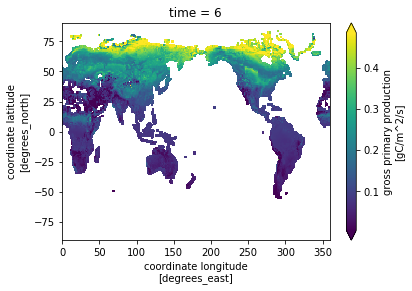

In [25]:
GPPclimo = ds_climo.GPP
GPPwgt   = GPPclimo / GPPclimo.sum(dim='time') 
print(GPPwgt.shape)
GPPwgt.isel(time=6).plot(robust=True); 

In [26]:
import bottleneck
# also try weighting correlation based on monthly contribution to annual flux
# This is code that's likely better suited for a 3rd partly library like esmlab
# TODO, file issue with requst for these kinds of statistical functions

def covariance_gufunc(x, y):
    return ((x - x.mean(axis=-1, keepdims=True))
            * (y - y.mean(axis=-1, keepdims=True))).mean(axis=-1)

def pearson_correlation_gufunc(x, y):
    return covariance_gufunc(x, y) / (x.std(axis=-1) * y.std(axis=-1))

def pearson_correlation(x, y, dim):
    return xr.apply_ufunc(
        pearson_correlation_gufunc, x, y,
        input_core_dims=[[dim], [dim]],
        dask='parallelized',
        output_dtypes=[float])

# for weighted coorelation
def covariance_gufunc_wgt(x, y, w):
    return ((w * x - (x*w).mean(axis=-1, keepdims=True))
            * (y - (y*w).mean(axis=-1, keepdims=True))).mean(axis=-1)

def pearson_correlation_gufunc_wgt(x, y, w):
    return covariance_gufunc_wgt(x, y, w) / np.sqrt(
        covariance_gufunc_wgt(x, x, w) * covariance_gufunc_wgt(y,y,w))

def pearson_correlation_wgt(x, y, w, dim):
    return xr.apply_ufunc(
        pearson_correlation_gufunc_wgt, x, y, w,
        input_core_dims=[[dim], [dim], [dim]],
        dask='parallelized',
        output_dtypes=[float])

# rank correlation
def spearman_correlation_gufunc(x, y):
    x_ranks = bottleneck.rankdata(x, axis=-1)
    y_ranks = bottleneck.rankdata(y, axis=-1)
    return pearson_correlation_gufunc(x_ranks, y_ranks)

def spearman_correlation(x, y, dim):
    return xr.apply_ufunc(
        spearman_correlation_gufunc, x, y,
        input_core_dims=[[dim], [dim]],
        dask='parallelized',
        output_dtypes=[float])


In [27]:
print(svd0.vectors[:,0,:,:].shape)

(12, 192, 288)


In [28]:
# subset data arrays for processing & shape correctly
GPPvector_0 = svd0.vectors[:,0,:,:]
GPPvector_1 = svd0.vectors[:,1,:,:]
print(GPPvector_0.shape)
TBOTvector_0 = svd1.vectors[:,0,:,:]
TBOTvector_1 = svd1.vectors[:,1,:,:]
SMOIvector_0 = svd2.vectors[:,0,:,:]
SMOIvector_1 = svd2.vectors[:,1,:,:]
#print('GPPclimo.time = ', GPPclimo['time'])
#print('svd0.time = ', svd0.time)
#print('Tbot_v0.time = ',TBOTvector_0.time)
#print('Smoi_v0.time = ',SMOIvector_0.time)
GPPclimo['time'] =  GPPvector_0['time'] = svd0.time  # get time coords to match
#print()
#print(GPPvector_0.shape)

(12, 192, 288)


In [29]:
# now calculate the correlations
GPPp_0 = pearson_correlation(GPPclimo, GPPvector_0, 'time')  #GPP climatology vs. vectors
GPPp_1 = pearson_correlation(GPPclimo, GPPvector_1, 'time')  
GPPw_0 = pearson_correlation_wgt(GPPclimo, GPPvector_0, GPPwgt, 'time') 
GPPw_1 = pearson_correlation_wgt(GPPclimo, GPPvector_1, GPPwgt, 'time')
GPPr_0 = spearman_correlation(GPPclimo, GPPvector_0, 'time') 
GPPr_1 = spearman_correlation(GPPclimo, GPPvector_1, 'time')

print(TBOTvector_0.shape)
GPP_0_TBOT_0 = spearman_correlation(GPPvector_0, TBOTvector_0,'time') #GPP vectors vs. temp & mositure
GPP_0_SMOI_0 = spearman_correlation(GPPvector_0, SMOIvector_0,'time')
GPP_0_TBOT_1 = spearman_correlation(GPPvector_0, TBOTvector_1,'time')
GPP_0_SMOI_1 = spearman_correlation(GPPvector_0, SMOIvector_1,'time')

GPP_1_TBOT_0 = spearman_correlation(GPPvector_1, TBOTvector_0,'time')
GPP_1_SMOI_0 = spearman_correlation(GPPvector_1, SMOIvector_0,'time')
GPP_1_TBOT_1 = spearman_correlation(GPPvector_1, TBOTvector_1,'time')
GPP_1_SMOI_1 = spearman_correlation(GPPvector_1, SMOIvector_1,'time')

print(GPPp_0)
print(GPPw_0)
print()
print(xr.ufuncs.fabs(GPPr_0).max())

/glade/u/home/wwieder/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/glade/u/home/wwieder/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in sqrt


(12, 192, 288)
<xarray.DataArray (lat: 192, lon: 288)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
<xarray.DataArray (lat: 192, lon: 288)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8

<xarray.

### Make plots to visualize results

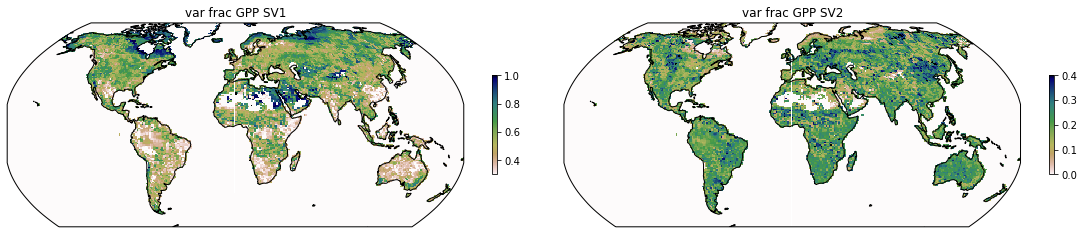

In [30]:
# just look at fraction of variance explained in GPP for each vector

import matplotlib.colors as colors
import cartopy.feature as cfeature
import cartopy.crs as ccrs

vmax = 1.
vmin = 0.3

fig = plt.figure(figsize=(16,20))

ax1 = fig.add_subplot(1,2,1,projection=ccrs.Robinson())
im1 = ax1.pcolormesh(svd0.lon.values,svd0.lat.values,svd0.varfrac.values[0,:,:],
                     transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im1,ax=ax1,shrink=0.07,label='')
ax1.coastlines()
ax1.set_title('var frac GPP SV1')
ax1.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())


vmax = 0.4
vmin = 0.
ax2 = fig.add_subplot(1,2,2,projection=ccrs.Robinson())
im2 = ax2.pcolormesh(svd0.lon.values,svd0.lat.values,svd0.varfrac.values[1,:,:],
                     transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im2,ax=ax2,shrink=0.07,label='')
ax2.coastlines()
ax2.set_title('var frac GPP SV2')
ax2.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())
fig.tight_layout()


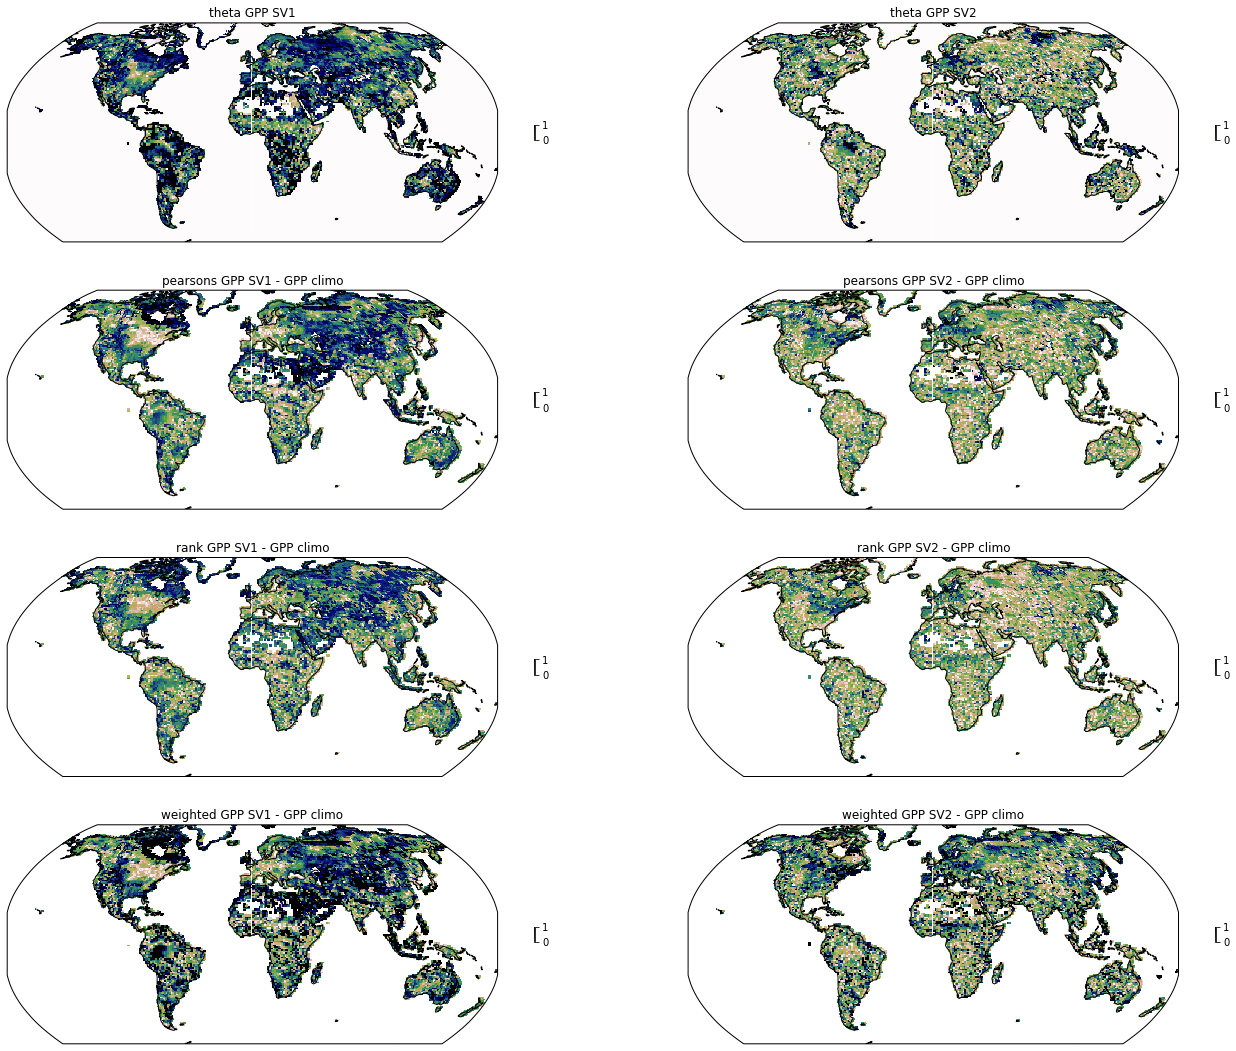

In [31]:
# theta values, 
# High theta values consistent with amplification vector?
# JH, there must be a more efficient way to make panel plots?!
vmax = 1.
vmin = 0.
fig = plt.figure(figsize=(20,15))

ax1 = fig.add_subplot(4,2,1,projection=ccrs.Robinson())
im1 = ax1.pcolormesh(svd0.lon.values,svd0.lat.values,svd0.theta.values[0,:,:],
                     transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im1,ax=ax1,shrink=0.07,label='')
ax1.coastlines()
ax1.set_title('theta GPP SV1')
ax1.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())

ax2 = fig.add_subplot(4,2,2,projection=ccrs.Robinson())
im2 = ax2.pcolormesh(svd0.lon.values,svd0.lat.values,svd0.theta.values[1,:,:],
                     transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im2,ax=ax2,shrink=0.07,label='')
ax2.coastlines()
ax2.set_title('theta GPP SV2')
ax2.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())

# correlation of vectors with climatology
vmax = 1.
vmin = 0.
ax3 = fig.add_subplot(4,2,3,projection=ccrs.Robinson())
im3 = ax3.pcolormesh(GPPp_0.lon.values,GPPp_0.lat.values,xr.ufuncs.fabs(GPPp_0),
                     transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im3,ax=ax3,shrink=0.07,label='')
ax3.coastlines()
ax3.set_title('pearsons GPP SV1 - GPP climo')
ax3.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())

ax4 = fig.add_subplot(4,2,4,projection=ccrs.Robinson())
im4 = ax4.pcolormesh(GPPp_1.lon.values,GPPp_1.lat.values,xr.ufuncs.fabs(GPPp_1),
                     transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im4,ax=ax4,shrink=0.07,label='')
ax4.coastlines()
ax4.set_title('pearsons GPP SV2 - GPP climo')
ax4.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())

ax5 = fig.add_subplot(4,2,5,projection=ccrs.Robinson())
im5 = ax5.pcolormesh(GPPr_0.lon.values,GPPr_0.lat.values,xr.ufuncs.fabs(GPPr_0),
                     transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im5,ax=ax5,shrink=0.07,label='')
ax5.coastlines()
ax5.set_title('rank GPP SV1 - GPP climo')
ax5.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())

ax6 = fig.add_subplot(4,2,6,projection=ccrs.Robinson())
im6 = ax6.pcolormesh(GPPr_1.lon.values,GPPr_1.lat.values,xr.ufuncs.fabs(GPPr_1),
                     transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im6,ax=ax6,shrink=0.07,label='')
ax6.coastlines()
ax6.set_title('rank GPP SV2 - GPP climo')
ax6.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())

ax7 = fig.add_subplot(4,2,7,projection=ccrs.Robinson())
im7 = ax7.pcolormesh(GPPw_0.lon.values,GPPw_0.lat.values,xr.ufuncs.fabs(GPPw_0),
                     transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im7,ax=ax7,shrink=0.07,label='')
ax7.coastlines()
ax7.set_title('weighted GPP SV1 - GPP climo')
ax7.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())

ax8 = fig.add_subplot(4,2,8,projection=ccrs.Robinson())
im8 = ax8.pcolormesh(GPPw_1.lon.values,GPPw_1.lat.values,xr.ufuncs.fabs(GPPw_1),
                     transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im8,ax=ax8,shrink=0.07,label='')
ax8.coastlines()
ax8.set_title('weighted GPP SV2 - GPP climo')
ax8.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())


fig.tight_layout();

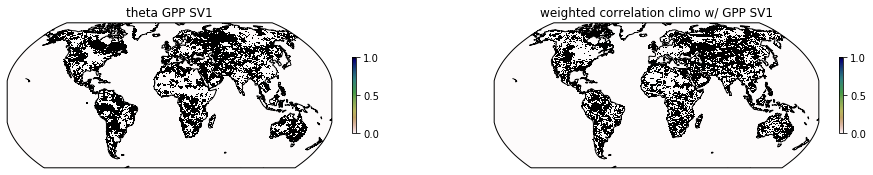

In [71]:
# Mask values to isolate regions with amplificaiton vs. early green-up?
minTheta = 0.75
maxTheta = 0.60
GPP_theta_mask1  = svd0.theta.isel(thetadim=0) > minTheta
GPP_theta_mask2  = svd0.theta.isel(thetadim=0) < maxTheta
GPP_climo_mask1 = xr.ufuncs.fabs(GPPw_0) > xr.ufuncs.fabs(GPPw_1)  
GPP_climo_mask2 = xr.ufuncs.fabs(GPPw_1) > xr.ufuncs.fabs(GPPw_0)  
fig = plt.figure(figsize=(16,20))

ax1 = fig.add_subplot(1,2,1,projection=ccrs.Robinson())
im1 = ax1.pcolormesh(GPP_theta_mask1.lon.values,GPP_theta_mask1.lat.values,GPP_theta_mask1.values[:,:],
                     transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im1,ax=ax1,shrink=0.07,label='')
ax1.coastlines()
ax1.set_title('theta GPP SV1')
ax1.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())

ax2 = fig.add_subplot(1,2,2,projection=ccrs.Robinson())
im2 = ax2.pcolormesh(GPP_climo_mask1.lon.values,GPP_climo_mask1.lat.values,GPP_climo_mask1.values[:,:],
                     transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im2,ax=ax2,shrink=0.07,label='')
ax2.coastlines()
ax2.set_title('weighted correlation climo w/ GPP SV1')
ax2.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())

#print(GPP_theta_mask)
#                     ds_anom.where(ds_anom.get(var[0]).max(dim='time'))    #mask out regions with no GPP in all variables


In [127]:
# calculate mean annual cycle and mean SV1 and SV2 for different regions
a = 55
b = 85
mean_GPPclimo = GPPclimo.where(GPP_theta_mask1).sel(lat=slice(a,b)).mean(('lat','lon')) 
mean_TBOTclimo = ds_climo.TBOT.where(GPP_theta_mask1).sel(lat=slice(a,b)).mean(('lat','lon')) 
mean_SOIMOIclimo = ds_climo.SOILWATER_10CM.where(GPP_theta_mask1).sel(lat=slice(a,b)).mean(('lat','lon')) 
mean_svd0 = svd0.where(GPP_theta_mask1).sel(lat=slice(a,b)).mean(('lat','lon')) 
mean_svd1 = svd1.where(GPP_theta_mask1).sel(lat=slice(a,b)).mean(('lat','lon')) 
mean_svd2 = svd2.where(GPP_theta_mask1).sel(lat=slice(a,b)).mean(('lat','lon')) 
print(mean_svd0.dims)
print(mean_GPPclimo)

mean_GPPclimoB = GPPclimo.where(GPP_climo_mask2).sel(lat=slice(a,b)).mean(('lat','lon')) 
mean_TBOTclimoB = ds_climo.TBOT.where(GPP_theta_mask2).sel(lat=slice(a,b)).mean(('lat','lon')) 
mean_SOIMOIclimoB = ds_climo.SOILWATER_10CM.where(GPP_theta_mask2).sel(lat=slice(a,b)).mean(('lat','lon')) 
mean_svd0B = svd0.where(GPP_climo_mask2).sel(lat=slice(a,b)).mean(('lat','lon')) 
mean_svd1B = svd1.where(GPP_climo_mask2).sel(lat=slice(a,b)).mean(('lat','lon')) 
mean_svd2B = svd2.where(GPP_climo_mask2).sel(lat=slice(a,b)).mean(('lat','lon')) 

Frozen(SortedKeysDict({'thetadim': 25, 'time': 12, 'vectors_dim1': 25, 'weights_dim1': 25, 'weights_dim2': 25}))
<xarray.DataArray 'GPP' (time: 12)>
array([3.9343175e-07, 8.0814010e-07, 2.4603323e-06, 8.2716606e-06,
       2.1620273e-05, 5.6740198e-05, 7.5039548e-05, 5.3456810e-05,
       2.8149600e-05, 7.0925062e-06, 1.1318415e-06, 3.8739731e-07],
      dtype=float32)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 10 11
Attributes:
    long_name:     gross primary production
    units:         gC/m^2/s
    cell_methods:  time: mean


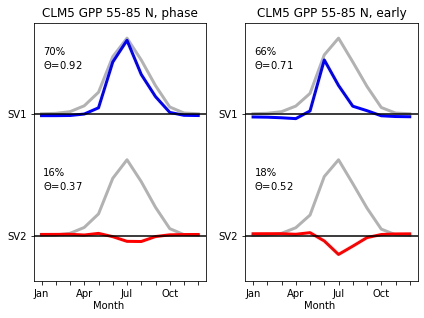

In [130]:
# Plot First and Second Singular Vectors
fig = plt.figure(4,figsize=(6,4.5))
barwidth = 0.2
month = np.arange(12)
multi =0.9e4        #This is a totally arbitrary scale factor, decided by me, to make figures look good!
ymax=np.max(mean_svd0.vectors.values)

# --- GPPP, SVD 1 & 2 for regions in phase with GPP 
vectors2plot=mean_svd0.vectors*multi  
mm2plot = mean_GPPclimo.values

ax1 = fig.add_subplot(1,2,1)
ax1.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))-0.05,'k-',alpha=0.3,linewidth=3)
ax1.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))+0.35,'k-',alpha=0.3,linewidth=3)
ax1.plot(np.array(month)+2*barwidth,vectors2plot[:,0]*0.75+0.35,'b-',linewidth=3)
ax1.plot(np.array(month)+2*barwidth,-vectors2plot[:,1]*0.75-0.05,'r-',linewidth=3)
ax1.axhline(-0.05,color='black')
ax1.axhline(0.35,color='black')
ax1.set_xticks(np.array(month)+2*barwidth)
ax1.set_xticklabels(['Jan','','','Apr','','','Jul','','','Oct','',''])
ax1.set_yticks([-0.05,0.35])
ax1.set_yticklabels(['SV2','SV1'])
ax1.set_ylim([-0.2,0.65])

ax1.text(0.5,.50,str(int(mean_svd0.varfrac[0]*100))+"%\n$\Theta$="+str('%.2f'%mean_svd0.theta[0]))
ax1.text(0.5,.10,str(int(mean_svd0.varfrac[1]*100))+"%\n$\Theta$="+str('%.2f'%mean_svd0.theta[1]))
ax1.title.set_text('CLM5 '+var[0]+" "+str(a)+"-"+str(b)+" N, phase")
ax1.text(4,-0.29,'Month')

vectors2plot=mean_svd0B.vectors*multi  
mm2plot = mean_GPPclimoB.values
ax2 = fig.add_subplot(1,2,2)
ax2.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))-0.05,'k-',alpha=0.3,linewidth=3)
ax2.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))+0.35,'k-',alpha=0.3,linewidth=3)
ax2.plot(np.array(month)+2*barwidth,vectors2plot[:,0]*0.75+0.35,'b-',linewidth=3)
ax2.plot(np.array(month)+2*barwidth,-vectors2plot[:,1]*0.75-0.05,'r-',linewidth=3)
ax2.axhline(-0.05,color='black')
ax2.axhline(0.35,color='black')
ax2.set_xticks(np.array(month)+2*barwidth)
ax2.set_xticklabels(['Jan','','','Apr','','','Jul','','','Oct','',''])
ax2.set_yticks([-0.05,0.35])
ax2.set_yticklabels(['SV2','SV1'])
ax2.set_ylim([-0.2,0.65])

ax2.text(0.5,.50,str(int(mean_svd0B.varfrac[0]*100))+"%\n$\Theta$="+str('%.2f'%mean_svd0B.theta[0]))
ax2.text(0.5,.10,str(int(mean_svd0B.varfrac[1]*100))+"%\n$\Theta$="+str('%.2f'%mean_svd0B.theta[1]))
ax2.title.set_text('CLM5 '+var[0]+" "+str(a)+"-"+str(b)+" N, early")
ax2.text(4,-0.29,'Month')

plt.tight_layout();

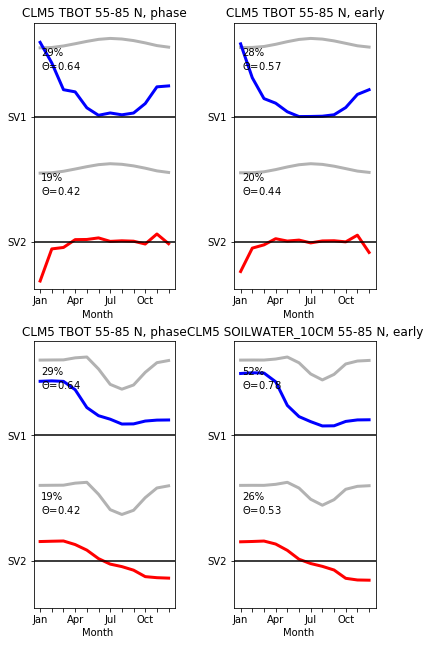

In [131]:
# Plot First and Second Singular Vectors
fig = plt.figure(4,figsize=(6,9))
barwidth = 0.2
month = np.arange(12)
multi =4.e-2        #This is a totally arbitrary scale factor, decided by me, to make figures look good!
ymax=np.max(mean_svd1.vectors.values)
vectors2plot=mean_svd1.vectors*multi  
mm2plot = mean_TBOTclimo.values

# --- TBOT, where GPP SVD1 is in phase with climatology ---
ax1 = fig.add_subplot(2,2,1)
ax1.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))-0.05,'k-',alpha=0.3,linewidth=3)
ax1.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))+0.35,'k-',alpha=0.3,linewidth=3)
ax1.plot(np.array(month)+2*barwidth,-vectors2plot[:,0]*0.75+0.35,'b-',linewidth=3)
ax1.plot(np.array(month)+2*barwidth,-vectors2plot[:,1]*0.75-0.05,'r-',linewidth=3)
ax1.axhline(-0.05,color='black')
ax1.axhline(0.35,color='black')
ax1.set_xticks(np.array(month)+2*barwidth)
ax1.set_xticklabels(['Jan','','','Apr','','','Jul','','','Oct','',''])
ax1.set_yticks([-0.05,0.35])
ax1.set_yticklabels(['SV2','SV1'])
ax1.set_ylim([-0.2,0.65])

ax1.text(0.5,.50,str(int(mean_svd1.varfrac[0]*100))+"%\n$\Theta$="+str('%.2f'%mean_svd1.theta[0]))
ax1.text(0.5,.10,str(int(mean_svd1.varfrac[1]*100))+"%\n$\Theta$="+str('%.2f'%mean_svd1.theta[1]))
ax1.title.set_text('CLM5 '+var[1]+" "+str(a)+"-"+str(b)+" N, phase")
ax1.text(4,-0.29,'Month')

# --- TBOT, where GPP SVD1 is NOT in phase with climatology ---
vectors2plot=mean_svd1B.vectors*multi  
mm2plot = mean_TBOTclimoB.values
ax2 = fig.add_subplot(2,2,2)
ax2.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))-0.05,'k-',alpha=0.3,linewidth=3)
ax2.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))+0.35,'k-',alpha=0.3,linewidth=3)
ax2.plot(np.array(month)+2*barwidth,-vectors2plot[:,0]*0.75+0.35,'b-',linewidth=3)
ax2.plot(np.array(month)+2*barwidth,-vectors2plot[:,1]*0.75-0.05,'r-',linewidth=3)
ax2.axhline(-0.05,color='black')
ax2.axhline(0.35,color='black')
ax2.set_xticks(np.array(month)+2*barwidth)
ax2.set_xticklabels(['Jan','','','Apr','','','Jul','','','Oct','',''])
ax2.set_yticks([-0.05,0.35])
ax2.set_yticklabels(['SV2','SV1'])
ax2.set_ylim([-0.2,0.65])

ax2.text(0.5,.50,str(int(mean_svd1B.varfrac[0]*100))+"%\n$\Theta$="+str('%.2f'%mean_svd1B.theta[0]))
ax2.text(0.5,.10,str(int(mean_svd1B.varfrac[1]*100))+"%\n$\Theta$="+str('%.2f'%mean_svd1B.theta[1]))
ax2.title.set_text('CLM5 '+var[1]+" "+str(a)+"-"+str(b)+" N, early")
ax2.text(4,-0.29,'Month')

# --- Soil moisture, where GPP SVD1 is in phase with climatology ---
multi =9.e-3        #This is a totally arbitrary scale factor, decided by me, to make figures look good!
ymax=np.max(mean_svd2.vectors.values)
vectors2plot=mean_svd2.vectors*multi  
mm2plot = mean_SOIMOIclimo.values

ax3 = fig.add_subplot(2,2,3)
ax3.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))-0.05,'k-',alpha=0.3,linewidth=3)
ax3.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))+0.35,'k-',alpha=0.3,linewidth=3)
ax3.plot(np.array(month)+2*barwidth,-vectors2plot[:,0]*0.75+0.35,'b-',linewidth=3)
ax3.plot(np.array(month)+2*barwidth,-vectors2plot[:,1]*0.75-0.05,'r-',linewidth=3)
ax3.axhline(-0.05,color='black')
ax3.axhline(0.35,color='black')
ax3.set_xticks(np.array(month)+2*barwidth)
ax3.set_xticklabels(['Jan','','','Apr','','','Jul','','','Oct','',''])
ax3.set_yticks([-0.05,0.35])
ax3.set_yticklabels(['SV2','SV1'])
ax3.set_ylim([-0.2,0.65])

ax3.text(0.5,.50,str(int(mean_svd1.varfrac[0]*100))+"%\n$\Theta$="+str('%.2f'%mean_svd1.theta[0]))
ax3.text(0.5,.10,str(int(mean_svd1.varfrac[1]*100))+"%\n$\Theta$="+str('%.2f'%mean_svd1.theta[1]))
ax3.title.set_text('CLM5 '+var[1]+" "+str(a)+"-"+str(b)+" N, phase")
ax3.text(4,-0.29,'Month')

# --- Soil moisture, where GPP SVD1 is NOT in phase with climatology ---
vectors2plot=mean_svd2B.vectors*multi  
mm2plot = mean_SOIMOIclimoB.values
ax4 = fig.add_subplot(2,2,4)
ax4.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))-0.05,'k-',alpha=0.3,linewidth=3)
ax4.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))+0.35,'k-',alpha=0.3,linewidth=3)
ax4.plot(np.array(month)+2*barwidth,-vectors2plot[:,0]*0.75+0.35,'b-',linewidth=3)
ax4.plot(np.array(month)+2*barwidth,-vectors2plot[:,1]*0.75-0.05,'r-',linewidth=3)
ax4.axhline(-0.05,color='black')
ax4.axhline(0.35,color='black')
ax4.set_xticks(np.array(month)+2*barwidth)
ax4.set_xticklabels(['Jan','','','Apr','','','Jul','','','Oct','',''])
ax4.set_yticks([-0.05,0.35])
ax4.set_yticklabels(['SV2','SV1'])
ax4.set_ylim([-0.2,0.65])

ax4.text(0.5,.50,str(int(mean_svd2B.varfrac[0]*100))+"%\n$\Theta$="+str('%.2f'%mean_svd2B.theta[0]))
ax4.text(0.5,.10,str(int(mean_svd2B.varfrac[1]*100))+"%\n$\Theta$="+str('%.2f'%mean_svd2B.theta[1]))
ax4.title.set_text('CLM5 '+var[2]+" "+str(a)+"-"+str(b)+" N, early")
ax4.text(4,-0.29,'Month')

plt.tight_layout();


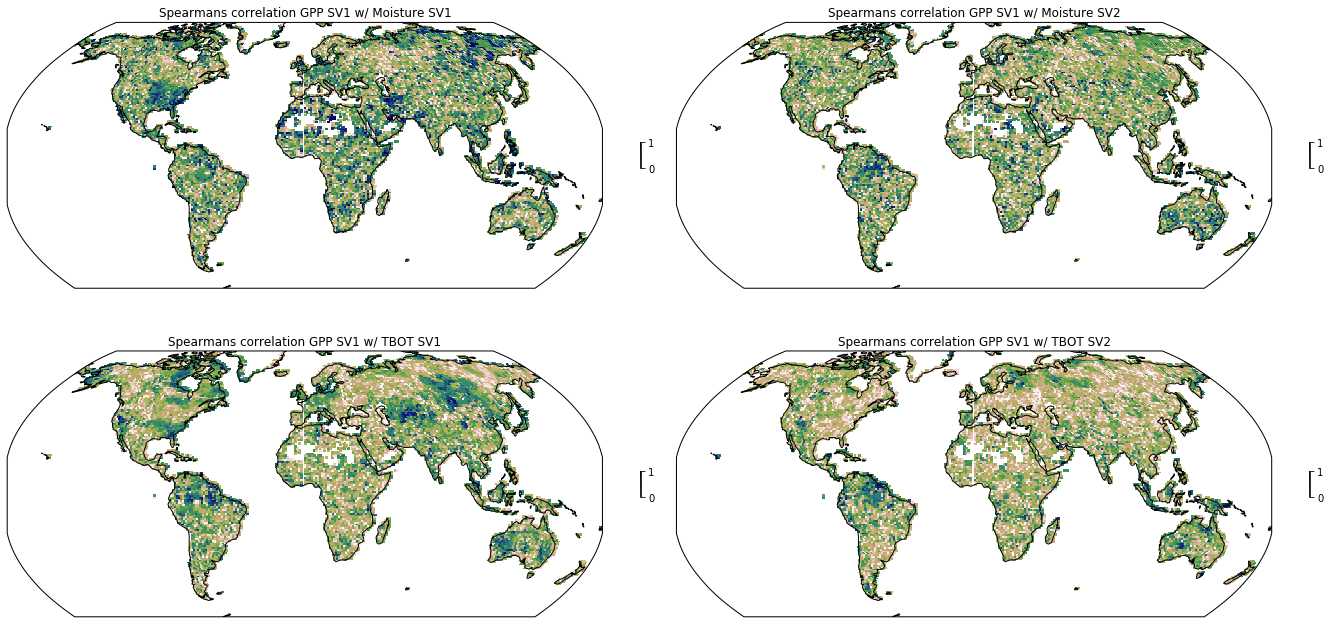

In [82]:
# plot correlations with soil moisture & Temp
fig = plt.figure(figsize=(20,10))

ax1 = fig.add_subplot(2,2,1,projection=ccrs.Robinson())
im1 = ax1.pcolormesh(GPP_0_SMOI_0.lon.values,GPP_0_SMOI_0.lat.values,xr.ufuncs.fabs(GPP_0_SMOI_0),transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im1,ax=ax1,shrink=0.07,label='')
ax1.coastlines()
ax1.set_title('Spearmans correlation GPP SV1 w/ Moisture SV1')
ax1.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())

ax2 = fig.add_subplot(2,2,2,projection=ccrs.Robinson())
im2 = ax2.pcolormesh(GPP_0_SMOI_1.lon.values,GPP_0_SMOI_1.lat.values,xr.ufuncs.fabs(GPP_0_SMOI_1),transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im2,ax=ax2,shrink=0.07,label='')
ax2.coastlines()
ax2.set_title('Spearmans correlation GPP SV1 w/ Moisture SV2')
ax2.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())
fig.tight_layout()

ax3 = fig.add_subplot(2,2,3,projection=ccrs.Robinson())
im3 = ax3.pcolormesh(GPP_0_TBOT_0.lon.values,GPP_0_TBOT_0.lat.values,xr.ufuncs.fabs(GPP_0_TBOT_0),transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im3,ax=ax3,shrink=0.07,label='')
ax3.coastlines()
ax3.set_title('Spearmans correlation GPP SV1 w/ TBOT SV1')
ax3.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())

ax4 = fig.add_subplot(2,2,4,projection=ccrs.Robinson())
im4 = ax4.pcolormesh(GPP_0_TBOT_1.lon.values,GPP_0_TBOT_1.lat.values,xr.ufuncs.fabs(GPP_0_TBOT_1),transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im4,ax=ax4,shrink=0.07,label='')
ax4.coastlines()
ax4.set_title('Spearmans correlation GPP SV1 w/ TBOT SV2')
ax4.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())
fig.tight_layout()

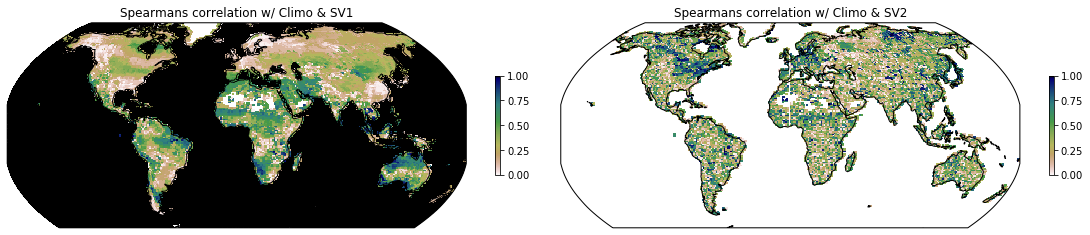

In [49]:
fig = plt.figure(figsize=(16,20))

ax1 = fig.add_subplot(1,2,1,projection=ccrs.Robinson())
im1 = ax1.pcolormesh(GPPr_0.lon.values,GPPr_0.lat.values,xr.ufuncs.fabs(GPPr_0),transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im1,ax=ax1,shrink=0.07,label='')
ax1.coastlines()
ax1.set_title('Spearmans correlation w/ Climo & SV1')
ax1.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())

ax2 = fig.add_subplot(1,2,2,projection=ccrs.Robinson())
im2 = ax2.pcolormesh(GPPr_1.lon.values,GPPr_1.lat.values,xr.ufuncs.fabs(GPPr_1),transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im2,ax=ax2,shrink=0.07,label='')
ax2.coastlines()
ax2.set_title('Spearmans correlation w/ Climo & SV2')
ax2.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())
fig.tight_layout()



TypeError: Dimensions of C (25, 192) are incompatible with X (288) and/or Y (192); see help(pcolormesh)

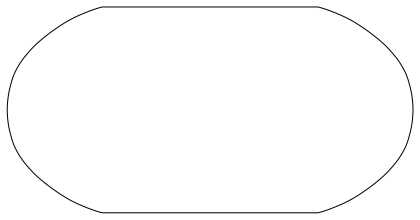

In [50]:
vmax = 1.
vmin = 0.
fig = plt.figure(figsize=(16,20))

ax1 = fig.add_subplot(1,2,1,projection=ccrs.Robinson())
im1 = ax1.pcolormesh(svd2.lon.values,svd2.lat.values,svd0.theta.values[:,:,0],transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im1,ax=ax1,shrink=0.07,label='')
ax1.coastlines()
ax1.set_title('$\Theta$ SV1')
ax1.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())

ax2 = fig.add_subplot(1,2,2,projection=ccrs.Robinson())
im2 = ax2.pcolormesh(svd2.lon.values,svd2.lat.values,svd0.theta.values[:,:,1],transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im2,ax=ax2,shrink=0.07,label='')
ax2.coastlines()
ax2.set_title('$\Theta$ SV2')
ax2.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())
fig.tight_layout()


<Figure size 360x252 with 0 Axes>

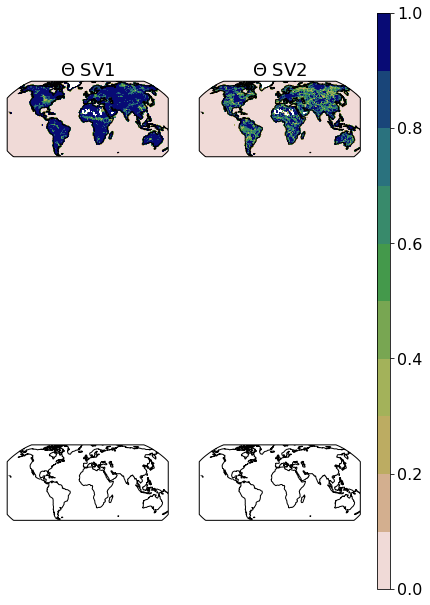

In [72]:
lat = svd2.coords['lat']
lon = svd2.coords['lon']
x0 = svd0.theta[:,:,0]
x1 = svd0.theta[:,:,1]

norm = colors.Normalize(vmin=0, vmax=1.)

# modified from https://unidata.github.io/MetPy/latest/examples/Four_Panel_Map.html
crs = ccrs.Robinson()#central_longitude=305.0)

# Function used to create the map subplots
def plot_background(ax):
    ax.set_global()
    ax.coastlines()
    #ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    return ax

levels = np.linspace(0, 1, 11)
fig = plt.figure(figsize=(5, 3.5),constrained_layout=True);
fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=(6, 10), constrained_layout=True,
                          subplot_kw={'projection': crs})

axlist = axarr.flatten()
for ax in axlist:
    plot_background(ax)
    ax.set_extent([-155, 60, -25, 60])  # I really don't understand how this works??
#    ax.set_extent([-150, 60, -25, 60])


# upper plot
cf0 = axlist[0].contourf(lon, lat, x0, levels=levels, norm=norm, cmap='gist_earth_r',
                 transform=ccrs.PlateCarree());
axlist[0].set_title('$\Theta$ SV1', fontsize=18)
axlist[0].set_axis_off()

# lower plot
cf1 = axlist[1].contourf(lon, lat, x1, levels=levels, norm=norm, cmap='gist_earth_r',
                 transform=ccrs.PlateCarree());
axlist[1].set_title('$\Theta$ SV2', fontsize=18)
axlist[1].set_axis_off()

# add common colorbar
cbar = fig.colorbar(cf1, ax=axlist.ravel().tolist(), 
                    orientation='vertical', shrink=0.80, pad=0)
#cbar.set_label('gC/m2/y', size=18, orientation='horizontal')
cbar.ax.tick_params(labelsize=16) 
ax = cbar.ax
#ax.text(0.2,-0.1,mean_dataset.attrs['units'], size=16,rotation=0)
plt.show();
